In [1]:
import json
from time import time

import torch
from torch import nn
from torch import optim

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn import datasets
from sklearn.cluster import HDBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

## Utility functions

In [2]:
def acc(y_true, y_pred):
    from scipy.stats import mode

    most_common_label = mode(y_true)[0]
    label_mapping = {}
    for cluster in np.unique(y_pred):
        if cluster == -1:  # if treated as noise by density-based algorithms
            label_mapping[cluster] = most_common_label
        else:
            true_label = mode(y_true[y_pred == cluster])[0]
            label_mapping[cluster] = true_label

    aligned_labels = np.array([label_mapping.get(pred) for pred in y_pred])
    return metrics.accuracy_score(y_true, aligned_labels)

In [3]:
def bench_estimator(estimator, name, data, labels, times=50):
    all_results = []
    for _ in range(times):
        t0 = time()
        cluster_labels = estimator.fit_predict(data)
        all_results.append(
            [
                time() - t0,
                acc(labels, cluster_labels),
                metrics.homogeneity_score(labels, cluster_labels),
                metrics.v_measure_score(labels, cluster_labels),
                metrics.adjusted_rand_score(labels, cluster_labels),
                metrics.adjusted_mutual_info_score(labels, cluster_labels),
                metrics.silhouette_score(
                    data, cluster_labels, metric="euclidean", sample_size=300
                ),
            ]
        )
    mean_results = np.mean(all_results, axis=0)
    return {
        "estimator": name,
        "elapsed_time": mean_results[0],
        "accuracy": mean_results[1],
        "homogeneity": mean_results[2],
        "v_measure": mean_results[3],
        "adjusted_rand_score": mean_results[4],
        "adjusted_mutual_info": mean_results[5],
        "silhouette_score": mean_results[6],
    }

In [27]:
def plot_training(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training History")
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
def plot_clusters(X, y):
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
    plt.title("Clusters")
    plt.colorbar()

## Deep Clustering

In [6]:
scaler = StandardScaler()
X, y = datasets.load_breast_cancer(return_X_y=True)
X_scaled = scaler.fit_transform(X)
X_tensor = torch.FloatTensor(X_scaled)
n_clusters = np.unique(y).size

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.1, random_state=42
)

X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, X_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

### Autoenkoder

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.2),
            nn.Linear(8, 4),
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.LeakyReLU(0.2),
            nn.Linear(8, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
input_dim = X_train.shape[1]
autoencoder = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [9]:
num_epochs = 500
train_losses = []
test_losses = []

for epoch in tqdm(range(num_epochs)):
    autoencoder.train()
    total_loss = 0
    for batch_features, _ in train_loader:
        optimizer.zero_grad()
        outputs = autoencoder(batch_features)
        loss = criterion(outputs, batch_features)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    autoencoder.eval()
    with torch.no_grad():
        test_outputs = autoencoder(X_test_tensor)
        test_loss = criterion(test_outputs, X_test_tensor)
        test_losses.append(test_loss.item())

100%|██████████| 500/500 [00:09<00:00, 54.83it/s]


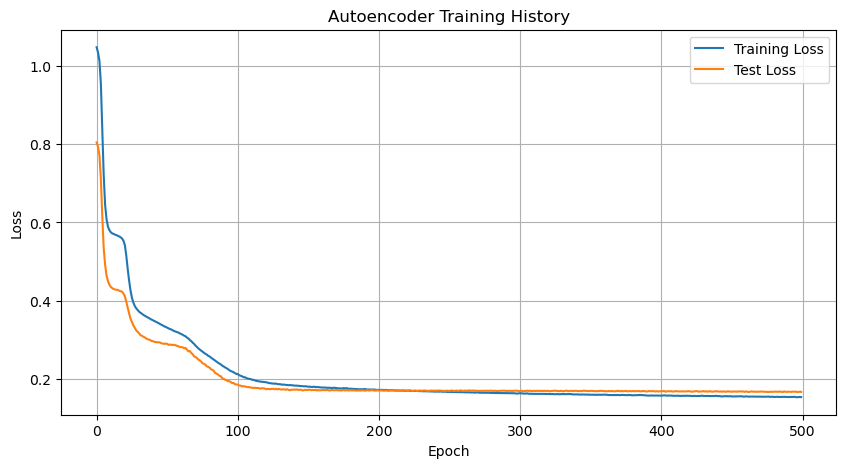

In [10]:
plot_training(train_losses, test_losses)

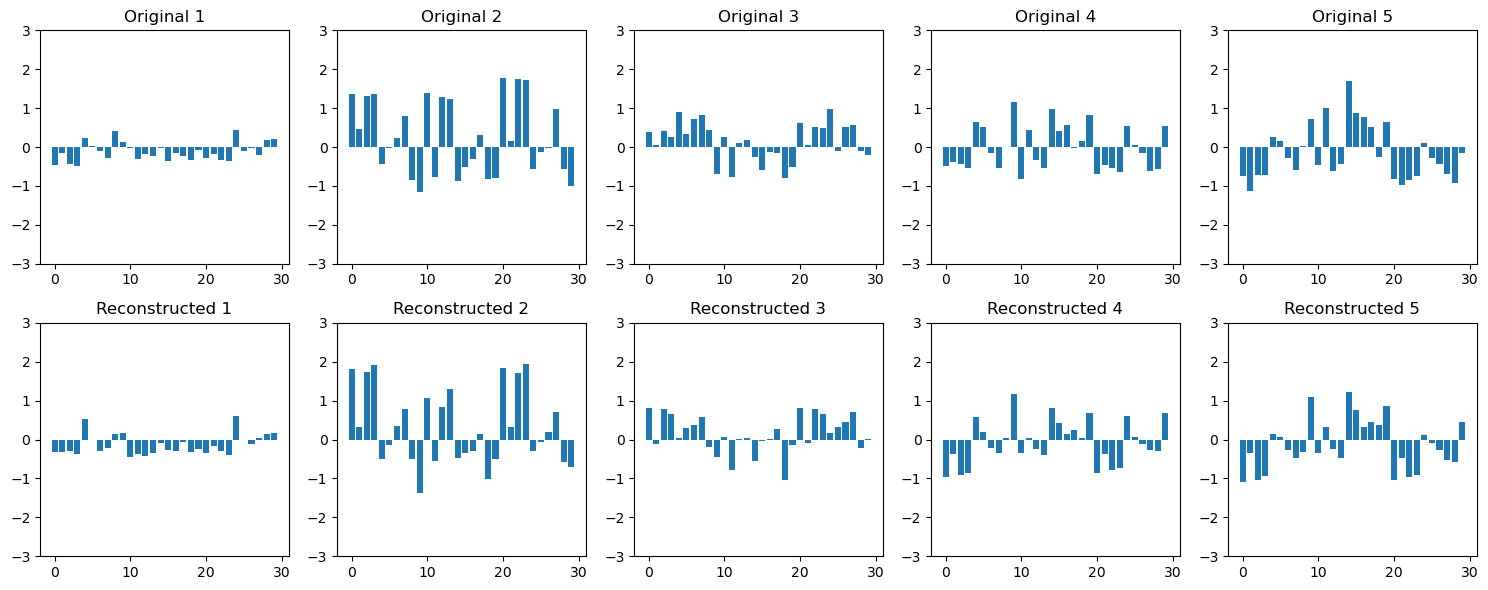

In [11]:
autoencoder.eval()
with torch.no_grad():
    sample = X_test_tensor[:5]
    reconstructed = autoencoder(sample)

sample_np = sample.numpy()
reconstructed_np = reconstructed.numpy()

plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.bar(range(input_dim), sample_np[i])
    plt.title(f"Original {i + 1}")
    plt.ylim(-3, 3)

    plt.subplot(2, 5, i + 6)
    plt.bar(range(input_dim), reconstructed_np[i])
    plt.title(f"Reconstructed {i + 1}")
    plt.ylim(-3, 3)

plt.tight_layout()
plt.show()

### Deep Embedding Clustering

In [12]:
class DEC(nn.Module):
    def __init__(self, autoencoder, n_clusters, initial_clusters, alpha=1.0):
        super(DEC, self).__init__()
        self.alpha = alpha
        self.autoencoder = autoencoder
        self.cluster_centers = nn.Parameter(torch.Tensor(n_clusters, 4))
        self.cluster_centers.data = initial_clusters

    def forward(self, x):
        encoded_X = self.autoencoder.encoder(x)
        norm_squared = torch.sum(
            (encoded_X.unsqueeze(1) - self.cluster_centers) ** 2, 2
        )
        numerator = 1.0 / (1.0 + (norm_squared / self.alpha))
        power = float(self.alpha + 1) / 2
        numerator = numerator**power
        t_dist = (numerator.t() / torch.sum(numerator, 1)).t()
        return t_dist

In [13]:
def target_distribution(q):
    weight = (q**2) / torch.sum(q, 0)
    return (weight.t() / torch.sum(weight, 1)).t()

In [14]:
with torch.no_grad():
    encoded_X = autoencoder.encoder(X_tensor).numpy()

kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4, random_state=0)
initial_clusters = kmeans.fit_predict(encoded_X)
accuracy = acc(y, initial_clusters)
print(f"initial Accuracy: {accuracy:.3f}")

initial Accuracy: 0.907


In [15]:
model = DEC(autoencoder, n_clusters, torch.tensor(kmeans.cluster_centers_))
criterion = nn.KLDivLoss(reduction="batchmean")
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [16]:
num_epochs = 200
row = []
train_losses = []
test_losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()

    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    target = target_distribution(outputs)
    loss = criterion(outputs.log(), target)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_target = target_distribution(test_outputs)
        test_loss = criterion(test_outputs.log(), test_target)
        test_losses.append(test_loss.item())

        out = test_outputs.argmax(1).numpy()
        row.append(
            [
                epoch,
                acc(y_test, out),
                metrics.homogeneity_score(y_test, out),
                metrics.v_measure_score(y_test, out),
                metrics.adjusted_rand_score(y_test, out),
                metrics.adjusted_mutual_info_score(y_test, out),
                metrics.silhouette_score(
                    X_test_tensor, out, metric="euclidean", sample_size=300
                ),
            ]
        )

df = pd.DataFrame(
    row,
    columns=[
        "epochs",
        "accuracy",
        "homogeneity_score",
        "v_measure",
        "adjusted_rand_index",
        "adjusted_mutual_info",
        "silhouette_score",
    ],
)
df

100%|██████████| 200/200 [00:02<00:00, 85.03it/s] 


,epochs,accuracy,homogeneity_score,v_measure,adjusted_rand_index,adjusted_mutual_info,silhouette_score
0,0,0.964912,0.768509,0.789921,0.857726,0.786594,0.344666
1,1,0.964912,0.768509,0.789921,0.857726,0.786594,0.344666
2,2,0.964912,0.768509,0.789921,0.857726,0.786594,0.344666
3,3,0.964912,0.768509,0.789921,0.857726,0.786594,0.344666
4,4,0.964912,0.768509,0.789921,0.857726,0.786594,0.344666
...,...,...,...,...,...,...,...
195,195,0.964912,0.768509,0.789921,0.857726,0.786594,0.344666
196,196,0.964912,0.768509,0.789921,0.857726,0.786594,0.344666
197,197,0.964912,0.768509,0.789921,0.857726,0.786594,0.344666
198,198,0.964912,0.768509,0.789921,0.857726,0.786594,0.344666


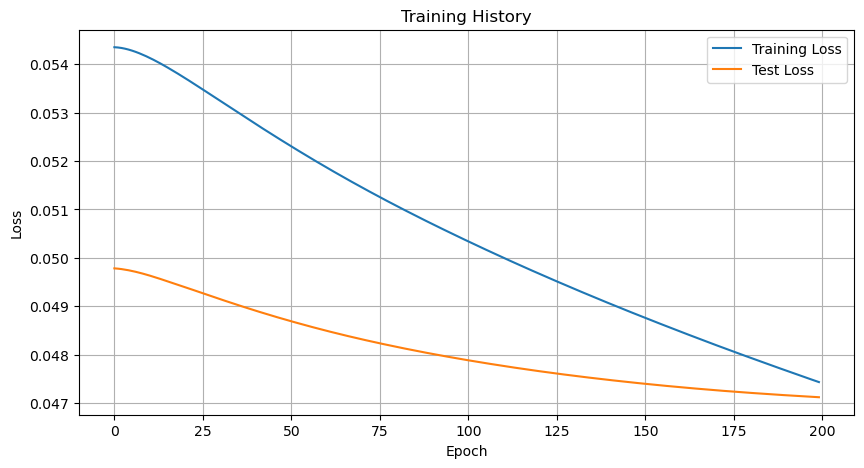

In [28]:
plot_training(train_losses, test_losses)

In [18]:
with torch.no_grad():
    outputs = model(X_tensor)
    final_clusters = outputs.argmax(1).numpy()

## Wyniki

Ground truth:

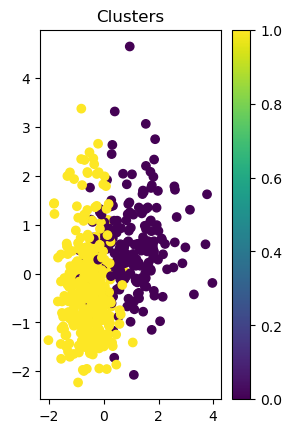

In [19]:
plot_clusters(X_scaled, y)

In [ ]:
print(metrics.homogeneity_score(y, y))
print(metrics.v_measure_score(y, y))
print(metrics.adjusted_rand_score(y, y))
print(metrics.adjusted_mutual_info_score(y, y))
print(metrics.silhouette_score(X_scaled, y, metric="euclidean", sample_size=300))

1.0
1.0
1.0
1.0
0.2704219101632432


### Kmeans++

In [20]:
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4, random_state=0)
results = bench_estimator(kmeans, "KMeans++", X_scaled, y)
print(json.dumps(results, indent=4))

{
    "estimator": "KMeans++",
    "elapsed_time": 0.10727187156677247,
    "accuracy": 0.9050966608084369,
    "homogeneity": 0.5248878197516512,
    "v_measure": 0.5324078598532427,
    "adjusted_rand_score": 0.6536246043910188,
    "adjusted_mutual_info": 0.5317737219826527,
    "silhouette_score": 0.341541904016132
}


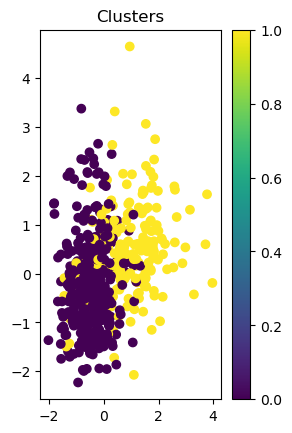

In [21]:
plot_clusters(X_scaled, kmeans.fit_predict(X_scaled))

Wysoka precyzja, z gorszymi miarami jednorodności i separacji klas. W miarę wysoki indeks AR świadczy o dobrym dopasowaniu między partycjami.

### HDBSCAN

In [22]:
hdbscan = HDBSCAN(min_cluster_size=10, min_samples=5)
results = bench_estimator(hdbscan, "HDBSCAN", X_scaled, y)
print(json.dumps(results, indent=4))

{
    "estimator": "HDBSCAN",
    "elapsed_time": 0.030272746086120607,
    "accuracy": 0.6502636203866426,
    "homogeneity": 0.22919792866896319,
    "v_measure": 0.212504733390165,
    "adjusted_rand_score": 0.15598711616690175,
    "adjusted_mutual_info": 0.2105040843246174,
    "silhouette_score": -0.027098978571215692
}


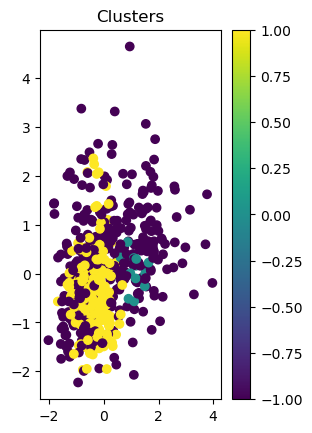

In [23]:
plot_clusters(X_scaled, hdbscan.fit_predict(X_scaled))

W tym zadaniu algorytm gęstościowy wypada słabo - niższa precyzja oraz słabo przypisane klasy w klastrach co widać po indeksie Silhoutte, który jest ujemny. Reszta miar jest bliska zeru, co w każdym przypadku świadczy o tym, że grupowanie jest nieadekwatne. 

Problem moim zdaniem występuje w doborze danych. Dataset jest niezłożony - co działa na korzyść kmeans, a w którym dane są gęste ale niełatwo separowalne (duża chmura, w której występuje wysoka różnorodność klas). Wysoka część danych jest klasyfikowana jako szum. Algorytm jest zato bardzo szybki, co zawdzięcza dzięki skomplikowaniu O(log n) - w przeciwieństwie do O(n^2) w Kmeans++.

### DEC

In [24]:
print(f"final accuracy: {df.iloc[-1]['accuracy']:.3f}")

final accuracy: 0.965


#### DEC ground truth

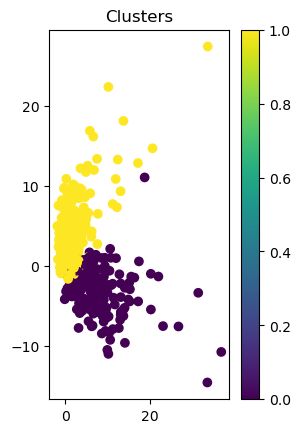

In [25]:
plot_clusters(encoded_X, y)

#### DEC wyniki

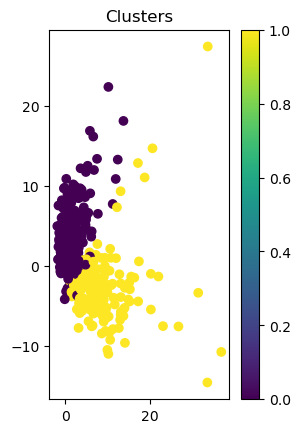

In [30]:
plot_clusters(encoded_X, final_clusters)

Model oparti na głębokim uczeniu prezentuje najwyższą precyzję, najlepszą separację klas (najwyższy indeks Silhoutte, może sugerować overfit) oraz bardzo dobrą jednorodność klastrów (wysokie miary "homogeneity", "v-measure", ARI i AMI). Jest też najszybszy - jedna epoka zajęła ok. 0.01s